In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# EXPERIMENT 2

In [23]:
data = pd.read_csv('../data/BTC-USD.csv')

In [25]:
# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Open', 'High', 'Low', 'Close', 'Volume']])

In [26]:
# Function to create sequences of data for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

In [27]:
# Define sequence length and split data into train and test sets
sequence_length = 10
X, y = create_sequences(scaled_data, sequence_length)
train_size = int(len(data) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [28]:
# Build LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(sequence_length, 5)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(5)
])

model.compile(optimizer='adam', loss='mean_squared_error')

E:\PROJECTS - AI\dl-bitcoin-price-prediction\env\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [29]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.1)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0281 - val_loss: 0.0034
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0029 - val_loss: 0.0014
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0021 - val_loss: 0.0016
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0017 - val_loss: 0.0026
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 10/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0013 - val_loss: 9.3721e-04
Epoch 11/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 12/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss:

In [30]:
# Predict the next 15 days
last_sequence = scaled_data[-40:-30]  # Extra 10 days for continuity
predictions_future = []

In [31]:
for _ in range(15):
    last_sequence_reshaped = last_sequence.reshape((1, sequence_length, 5))
    next_pred = model.predict(last_sequence_reshaped)
    next_pred = scaler.inverse_transform(next_pred)
    predictions_future.append(next_pred[0])
    last_sequence = np.append(last_sequence[1:], next_pred, axis=0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


In [32]:
predictions_future = np.array(predictions_future)

In [33]:
# Create a range of dates for the next 15 days
next_days = pd.date_range(start=data['Date'].iloc[-1], periods=15, freq='D')

In [34]:
# Filter the data for the last month
last_month_data = data.iloc[-30:]

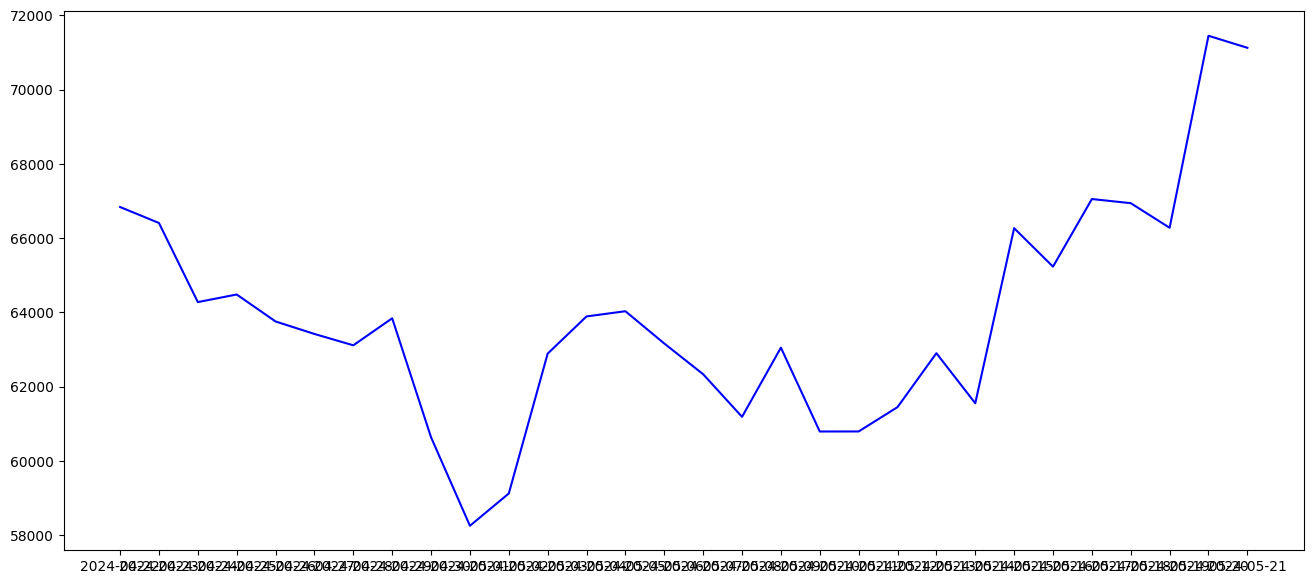

In [35]:
# Plot actual prices for the last month
plt.figure(figsize=(16,7))
plt.plot(last_month_data['Date'], last_month_data['Close'], label='Actual (Last Month)', color='blue')

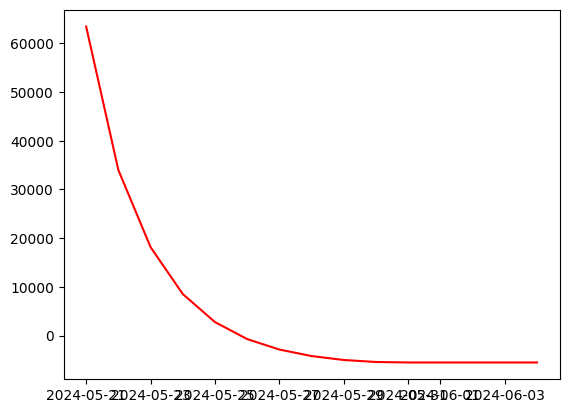

In [37]:
# Plot predicted prices for the next 15 days
plt.plot(next_days, predictions_future[:,3], label='Predicted (Next 15 Days)', color='red')

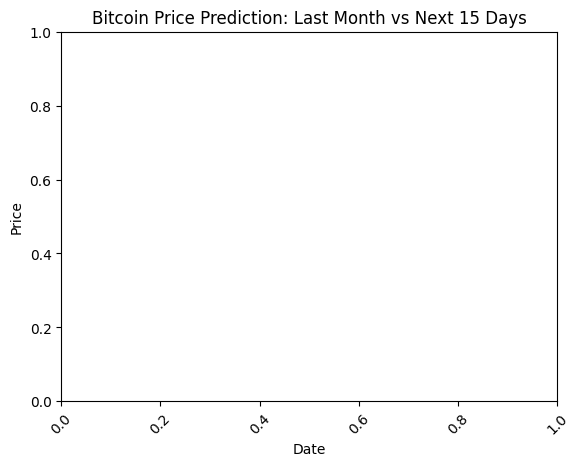

In [39]:
plt.title('Bitcoin Price Prediction: Last Month vs Next 15 Days')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [40]:
# For comparison of actual vs. predicted prices in test data
test_actual = data['Close'][train_size+sequence_length:].values

In [41]:
predicted_btc_price_test_data = model.predict(X_test)
predicted_btc_price_test_data = scaler.inverse_transform(predicted_btc_price_test_data)
predicted_btc_price_test_data = predicted_btc_price_test_data[:, 3]

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


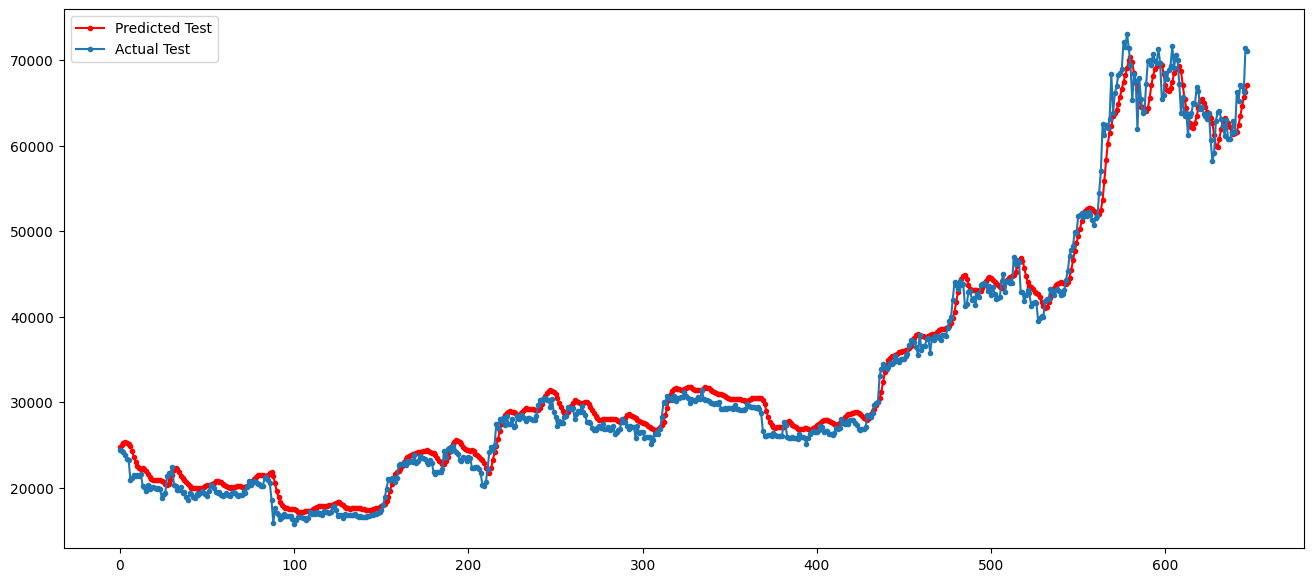

In [42]:
# Plot predicted vs actual test data
plt.figure(figsize=(16,7))
plt.plot(predicted_btc_price_test_data, 'r', marker='.', label='Predicted Test')
plt.plot(test_actual, marker='.', label='Actual Test')

plt.legend()
plt.show()

# EXPERIMENT 1

In [2]:
data = pd.read_csv('../data/BTC-USD.csv')

In [3]:
data = data[data['Date'] > '2023-05-21']

In [4]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
2923,2023-05-22,26749.892578,27045.734375,26549.734375,26851.277344,26851.277344,11056770492
2924,2023-05-23,26855.960938,27434.683594,26816.179688,27225.726563,27225.726563,13697203143
2925,2023-05-24,27224.603516,27224.603516,26106.576172,26334.818359,26334.818359,16299104428
2926,2023-05-25,26329.460938,26591.519531,25890.593750,26476.207031,26476.207031,13851122697
2927,2023-05-26,26474.181641,26916.669922,26343.949219,26719.291016,26719.291016,12711619225


In [5]:
data.shape

(366, 7)

In [6]:
# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Open', 'High', 'Low', 'Close', 'Volume']])

In [7]:
# Function to create sequences of data for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

In [8]:
# Define sequence length and split data into train and test sets
sequence_length = 10
X, y = create_sequences(scaled_data, sequence_length)
train_size = int(len(data) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [9]:
# Build LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(sequence_length, 5)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(5)
])

E:\PROJECTS - AI\dl-bitcoin-price-prediction\env\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [11]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.1)

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step - loss: 0.0468 - val_loss: 0.3041
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0195 - val_loss: 0.0972
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0067 - val_loss: 0.0163
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0083 - val_loss: 0.0307
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0060 - val_loss: 0.0567
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0051 - val_loss: 0.0481
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0043 - val_loss: 0.0295
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0038 - val_loss: 0.0213
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0036 - val_loss: 0.0291
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0037 - val_loss: 0.0291
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0034 - val_loss: 0.0194
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0036 - val_loss: 0.0175


In [12]:
# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0079 
Test Loss: 0.00777096301317215


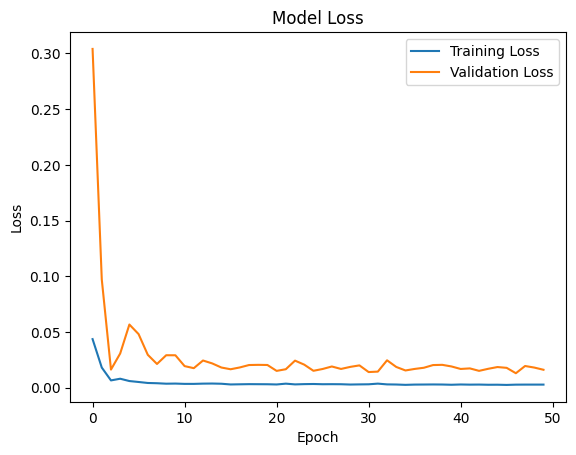

In [13]:
# Plot training & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [14]:
# Make predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
actual = scaler.inverse_transform(y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  


In [18]:
# Take the last 10 days of the dataset as input for prediction
last_sequence = scaled_data[-sequence_length:]

# Create a list to store the predictions
predictions_future = []

# Predict the next 15 days
for _ in range(15):
    # Reshape the last sequence to match the input shape of the model
    last_sequence_reshaped = last_sequence.reshape((1, sequence_length, 5))
    
    # Predict the next day's price
    next_pred = model.predict(last_sequence_reshaped)
    
    # Inverse transform the predicted price to get the original scale
    next_pred = scaler.inverse_transform(next_pred)
    
    # Append the predicted price to the predictions list
    predictions_future.append(next_pred[0])
    
    # Append the predicted price to the last sequence and remove the oldest price
    last_sequence = np.append(last_sequence[1:], next_pred, axis=0)

# Convert the predictions list to numpy array
predictions_future = np.array(predictions_future)

# Print the predicted prices for the next 15 days
print("Predicted prices for the next 15 days:")
print(predictions_future)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted prices for the next 15 days:
[[6.8143883e+04 6.7582523e+04 6.5529871e+04 6.7770547e+04 4.2536337e+10]
 [7.1411242e+04 6.9950492e+04 6.3928992e+04 7.0528273e+04 5.1958034e+10]
 [7.3135734e+04 7.0769570e+04 6.1916359e+04 7.0813828e+04 6.0070699e+10]
 [7.3986953e+04 7.1144602e+04 6.0286902e+04 7.0343461e+04 6.6459144e+10]
 [7.4205211e+04 7.1039648e+04 5.8840434e+04 6.9381289e+04 7.1241646e+10]
 [7.3667812e+04 7.0373266e

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


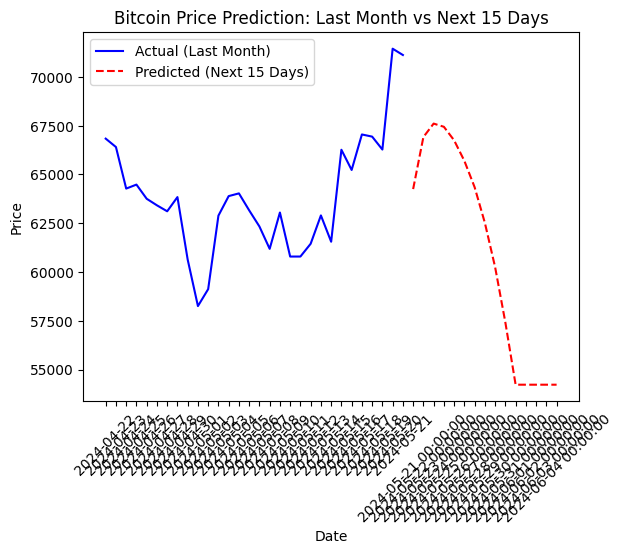

In [22]:
# Filter the data for the last month
last_month_data = data.iloc[-30:]

# Take the last 10 days of the last month as input for prediction
last_sequence = scaled_data[-40:-30]  # considering an extra 10 days for continuity

# Create a list to store the predictions
predictions_future = []

# Predict the next 15 days
for _ in range(15):
    # Reshape the last sequence to match the input shape of the model
    last_sequence_reshaped = last_sequence.reshape((1, sequence_length, 5))
    
    # Predict the next day's price
    next_pred = model.predict(last_sequence_reshaped)
    
    # Inverse transform the predicted price to get the original scale
    next_pred = scaler.inverse_transform(next_pred)
    
    # Append the predicted price to the predictions list
    predictions_future.append(next_pred[0])
    
    # Append the predicted price to the last sequence and remove the oldest price
    last_sequence = np.append(last_sequence[1:], next_pred, axis=0)

# Convert the predictions list to numpy array
predictions_future = np.array(predictions_future)

# Create a range of dates for the next 15 days
next_days = pd.date_range(start=last_month_data['Date'].iloc[-1], periods=15)

# Convert dates to strings for plotting
next_days_str = [str(date) for date in next_days]

# Plot actual prices for the last month
plt.plot(last_month_data['Date'], last_month_data['Close'], label='Actual (Last Month)', color='blue')

# Plot predicted prices for the next 15 days
plt.plot(next_days_str, predictions_future[:,3], label='Predicted (Next 15 Days)', linestyle='--', color='red')

plt.title('Bitcoin Price Prediction: Last Month vs Next 15 Days')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()